In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import torch
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
def labels_to_classes(labels,threshold=0.5):
    '''Convert class predictions into seperate channels per class.'''
    class_labels =[]
    for c in range(int(list(labels[0].shape)[0])):
        class_labels.append([float(labels[i][c]) for i in range(len(labels))])
    return class_labels

def one_hot(labels,classes):
    '''convert y labels into one hot form for loss function'''
    return torch.tensor([[1.0 if label == index else 0.0 for index in range(classes)] for label in labels])

def normalize_data(arr:np.ndarray, method:str):
    if method == 'mean':
        # for col in df:
        #     df[col] = df[col] / df[col].mean()
        return (
            np.mean(axis=0),
            None
        )
    else:
        if method == 'standard':
            scaler = StandardScaler()
            scaler.fit(arr)
        elif method == 'minmax':
            scaler = MinMaxScaler()
            scaler.fit(arr)
        return (
            scaler.transform(arr),
            scaler
        )

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
window = 60
class GunshotDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        X, _ = normalize_data(X, method='standard')
        self.X = torch.tensor(X,requires_grad=True,dtype=torch.float).to(device)
        self.y = torch.tensor(one_hot(y,4),requires_grad=True,dtype=torch.float).to(device)
        self.window_size = window
    
    def __len__(self):
        return len(self.X) - self.window_size
    
    def __getitem__(self, idx):
        # self.X[idx:idx+self.window_size].unsqueeze(0).T,
        return self.X[idx:idx+self.window_size].T, self.y[idx+self.window_size]

In [4]:
from torch import nn
class ResidualBlock(nn.Module):    
    def __init__(self,dim):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Conv1d(dim,dim,3,1,padding='same')
        self.bn = nn.BatchNorm1d(dim)
        self.do = nn.Dropout1d(0.2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        xc=  x.clone()
        x = self.relu(self.do(self.bn(self.conv(x))))
        return xc + x

class CNN1D(nn.Module):    
    def __init__(self, dim,depth,classes):
        super(CNN1D, self).__init__()
        self.blocks = nn.ParameterList()
        self.flatten = nn.Flatten()
        for _ in range(depth):
            self.blocks.append(ResidualBlock(dim))
        self.linear = nn.Linear(window*6,classes)
        self.output = nn.Softmax(dim=1)
        
    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        x = self.output(self.linear(self.flatten(x)))
        return x

In [5]:
def save_model(model, path:str) -> None:
        torch.save(model.state_dict(), path)

def load_model(path_to_saved_model, new_model):
    new_model.load_state_dict(torch.load(path_to_saved_model))
    return new_model

In [6]:
from torch.utils.data import DataLoader
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
from typing import Dict, List
import os
import matplotlib.pyplot as plt

def read_all_data(dir_path:str='processed_training_data') -> Dict[str, pd.DataFrame]:
    imu = pd.DataFrame()
    imu_t = pd.DataFrame()
    ann = pd.DataFrame()
    ann_t = pd.DataFrame()

    for f in os.listdir(dir_path):
        x = pd.read_csv(f'{dir_path}/{f}')
        if f[-7:] == '__x.csv':
            imu = pd.concat([imu, x], axis=0)
        
        elif f[-12:] == '__x_time.csv':
            imu_t = pd.concat([imu_t, x], axis=0)
            
        elif f[-7:] == '__y.csv':
            ann = pd.concat([ann, x], axis=0)
            
        elif f[-12:] == '__y_time.csv':
            ann_t = pd.concat([ann_t, x], axis=0)

    return {
        'imu': imu.reset_index(drop=True),
        'imu_t': imu_t.reset_index(drop=True),
        'ann': ann.reset_index(drop=True),
        'ann_t': ann_t.reset_index(drop=True)
    }
    
def get_distribution(all_y:List[float], num_classes:int=4) -> Dict[str, List[float]]:
    return {
        'counts': [all_y.count(x) for x in range(num_classes)],
        'fracs': [all_y.count(x)/len(all_y) for x in range(num_classes)]
    }

data_dict = read_all_data('/content/drive/MyDrive/Colab Notebooks/conv/processed_training_data')
imu = data_dict['imu'].to_numpy()
ann = data_dict['ann'].to_numpy().flatten()
del data_dict # Remove to free memory

weight_dist = get_distribution(ann.tolist())['fracs']

split = 0.8
batch_size = 512

split_idx = int(len(imu)*split)
X_train = imu[:split_idx]
X_val = imu[split_idx:]
y_train = ann[:split_idx]
y_val = ann[split_idx:]

train = GunshotDataset(X_train, y_train)
val = GunshotDataset(X_val, y_val)
training_data = DataLoader(train, batch_size=batch_size)
validation_data = DataLoader(val, batch_size=batch_size)

<ipython-input-3-80c3159dac18>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(one_hot(y,4),requires_grad=True,dtype=torch.float).to(device)
<ipython-input-3-80c3159dac18>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(one_hot(y,4),requires_grad=True,dtype=torch.float).to(device)


In [7]:
def cross_entropy_weights(percent_vector) -> torch.Tensor:
    inverse_fraction = [1/c for c in percent_vector]
    s = sum(inverse_fraction)
    weights = [f/s for f in inverse_fraction]
    return torch.tensor(weights)

def training_loop(model,training_data,validation_data,weight_dist,epochs=10):
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    weight = cross_entropy_weights(weight_dist).to(device)
    criterion = torch.nn.CrossEntropyLoss(weight=weight) # one-hot encoding taken care of by pytorch

    train_loss_history = []
    val_loss_history = []
    for epoch in range(1, epochs + 1):
        # Batch train
        model.train()
        batch_train_loss_history = []
        for (X, y) in tqdm(training_data):
            if X.shape[2] == train.window_size:
                optimizer.zero_grad()
                y_p = model(X)
                
                loss = criterion(y_p, y.to(device))

                loss.backward()
                optimizer.step()
                batch_train_loss_history.append(loss.item())
        
        # Batch validation
        model.eval()
        batch_val_loss_history = []
        for (X, y) in tqdm(validation_data):
            if X.shape[2] == val.window_size:
                with torch.no_grad():
                    y_p = model(X)
                loss = criterion(y_p, y.to(device))
                batch_val_loss_history.append(loss.item())
        
        # Batch average loss
        epoch_train_loss = sum(batch_train_loss_history) / len(batch_train_loss_history)
        epoch_val_loss = sum(batch_val_loss_history) / len(batch_val_loss_history)
        print(f'Training loss: {epoch_train_loss:.4f}\nValidation loss: {epoch_val_loss:.4f}') #
        
        # Append batch loss to epoch loss list
        train_loss_history.append(epoch_train_loss)
        val_loss_history.append(epoch_val_loss)
    
        save_model(model,'/content/drive/MyDrive/Colab Notebooks/conv/cnn_deep_res.model')

    return model,train_loss_history,val_loss_history

In [22]:
cnnres = CNN1D(6,5,4)
# r = torch.randn((batch_size,6,60))
# yp = cnnres(r)

In [ ]:
cnnres = load_model('/content/drive/MyDrive/Colab Notebooks/conv/cnn_deep_res.model',CNN1D(6,5,4)).to(device)
cnnres,train_plot,validation_plot = training_loop(cnnres,training_data,validation_data,weight_dist,20)

In [ ]:
def plot_loss(train_loss_history:List[float], val_loss_history:List[float]) -> None:
    plt.figure()
    plt.title('Loss curve')
    plt.plot(range(len(train_loss_history)), train_loss_history, label='train loss')
    plt.plot(range(len(train_loss_history)), val_loss_history, label='val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
plot_loss(train_plot,validation_plot)

  0%|          | 0/524 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


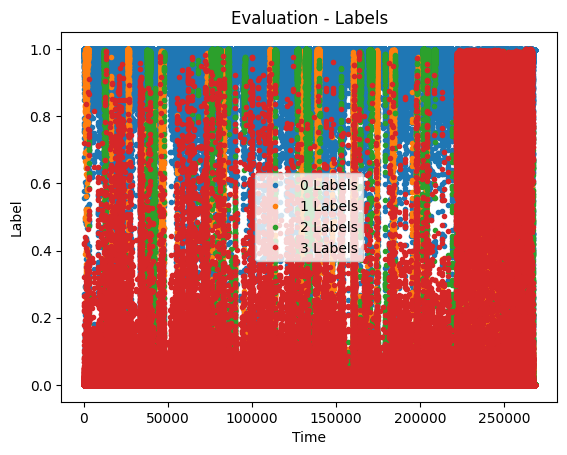

In [8]:

def evaluate(model,dataloader,plot=True):
    model_output = []
    for (X, y) in tqdm(dataloader):
        model.eval()
        with torch.no_grad():
            y_p = model(X)
        model_output.extend(y_p)
    classes = labels_to_classes(model_output)

    if plot:
        plt.figure()
        plt.title('Evaluation - Labels')
        for i,c in enumerate(classes):
            plt.plot(range(len(c)), c, '.',label=str(i) +' Labels')
        plt.xlabel('Time')
        plt.ylabel('Label')
        plt.legend()
        plt.show()

    return classes

cnnres = load_model('/content/drive/MyDrive/Colab Notebooks/conv/cnn_deep_res.model',CNN1D(6,5,4)).to(device)

c = evaluate(cnnres,validation_data,plot=True)

In [9]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 30.0 MB/s eta 0:00:00


In [19]:
import torchmetrics as tm
def stats(model:nn.Module, dataloader:torch.utils.data.DataLoader, num_classes) -> float:
    model.to('cpu')
    
    precision = tm.Precision(task="binary", average='macro')
    recall = tm.Recall(task="binary", average='macro')
    f_one = tm.F1Score(task="binary",average='macro')

    precisions = []
    recalls = []
    f_ones = []
    for (X, y) in tqdm(dataloader):
        X = X.to('cpu')
        y = y.to('cpu')
        model.eval()
        with torch.no_grad():
            y_p = model(X)
            recalls.append((recall(y_p,y)).item())
            precisions.append((precision(y_p,y)).item())
            f_ones.append((f_one(y_p,y)).item())
    return sum(precisions)/len(precisions), sum(recalls)/len(recalls), sum(f_ones)/len(f_ones)
stats(cnnres, validation_data, 4)

  0%|          | 0/524 [00:00<?, ?it/s]

(0.7278345985243004, 0.7230886211832062, 0.7254083154906114)

In [17]:
def eval_acc(model:torch.nn.Module, dataloader:torch.utils.data.DataLoader) -> float:
        model.to(device)
        ba = tm.classification.BinaryAccuracy(threshold=0.7).to(device)
        sum = 0
        length = 0
        for (X, y) in tqdm(dataloader):
            length += 1
            model.eval()
            with torch.no_grad():
                X.to(device)
                y_p = model(X)
                y_p.to(device)
                y.to(device)
                sum += ba(preds=y_p,target=y).item()
        return sum/length
eval_acc(cnnres,validation_data)

  0%|          | 0/524 [00:00<?, ?it/s]

0.8668688126192748